In [1]:
#import dependencies etc.
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
#connect to sqlite database
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# view classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#inspect tables so we know what columns we are dealing with
inspector = inspect(engine)
columns = inspector.get_columns("Measurement")
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#inspect tables so we know what columns we are dealing with
inspector = inspect(engine)
columns = inspector.get_columns("Station")
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Calculate the date 1 year ago from the last data point in the database
#find most recent date in database
newest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#retrieve 12 months worth of data - just date and precipitation scores
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_of_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

#store as dataframe
year_of_data = pd.DataFrame(year_of_data)

#drop missing values
year_of_data = year_of_data.dropna()

#sort by date
year_of_data = year_of_data.sort_values(by="date")

#set index to date column
year_of_data = year_of_data.set_index("date")

#display head to check
year_of_data.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


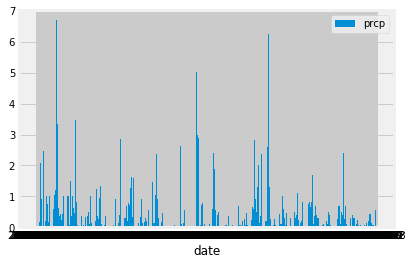

In [13]:
# Use Pandas Plotting with Matplotlib to plot precipitation over time
fig, ax = plt.subplots()
plt.bar(x = year_of_data.index, height = year_of_data["prcp"], label = "prcp")
plt.legend()
plt.xlabel("date")
ax.tick_params(right= True,top= True)
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_of_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).count()
num_stations

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()
station_counts = pd.DataFrame(station_counts, columns =['Station', 'Observations'])
station_counts = station_counts.sort_values(by="Observations", ascending=False)
station_counts = station_counts.reset_index()
station_counts

,index,Station,Observations
0,6,USC00519281,2772
1,7,USC00519397,2724
2,1,USC00513117,2709
3,8,USC00519523,2669
4,3,USC00516128,2612
5,2,USC00514830,2202
6,0,USC00511918,1979
7,4,USC00517948,1372
8,5,USC00518838,511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low_temp, = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
high_temp, = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
avg_temp, = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
print(f"The low temperature for Station USC00519281 is {low_temp[1]}")
print(f"The high temperature for Station USC00519281 is {high_temp[1]}")
print(f"The average temperature for Station USC00519281 is {avg_temp[1]}")

The low temperature for Station USC00519281 is 54.0
The high temperature for Station USC00519281 is 85.0
The average temperature for Station USC00519281 is 71.66378066378067


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_of_temp = session.query(Measurement.date, Measurement.tobs, Measurement.station).filter(Measurement.date >= query_date).filter(Measurement.station == "USC00519281").all()
year_of_temp = pd.DataFrame(year_of_temp)
year_of_temp.head() 

,date,tobs,station
0,2016-08-23,77.0,USC00519281
1,2016-08-24,77.0,USC00519281
2,2016-08-25,80.0,USC00519281
3,2016-08-26,80.0,USC00519281
4,2016-08-27,75.0,USC00519281


In [19]:
#bin data
#find minimum and maximum temperature
minimum = year_of_temp["tobs"].min()
maximum = year_of_temp["tobs"].max()

#create bins
bins = [59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83]
group_names = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l"]

year_of_temp["abc"] = pd.cut(year_of_temp["tobs"], bins, labels=group_names)
year_of_temp.head()

temp_counts = year_of_temp.groupby(year_of_temp["abc"]).count()
temp_counts = temp_counts.reset_index()
temp_counts

,abc,date,tobs,station
0,a,3,3,3
1,b,10,10,10
2,c,10,10,10
3,d,20,20,20
4,e,31,31,31
5,f,40,40,40
6,g,40,40,40
7,h,72,72,72
8,i,64,64,64
9,j,40,40,40


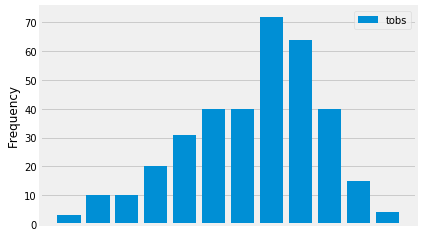

In [22]:
#create plot
fig, ax = plt.subplots()
x_axis = temp_counts["abc"]
plt.ylabel("Frequency")
plt.xticks(np.arange(59, 84, 5.0))

ax.grid(True)
ax.bar(temp_counts["abc"], temp_counts["tobs"], label = "tobs")
ax.legend()


In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps, = calc_temps("2017-03-05", "2017-03-15")
trip_temps

print(f"Minimum temp for trip date = {trip_temps[0]}")
print(f"Average temp for trip date = {trip_temps[1]}")
print(f"Maximum temp for trip date = {trip_temps[2]}")

Minimum temp for trip date = 62.0
Average temp for trip date = 70.70149253731343
Maximum temp for trip date = 82.0


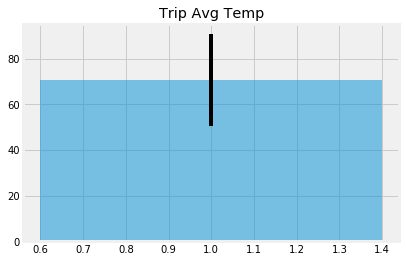

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
x_pos = 1
ax.bar(x_pos, trip_temps[1], yerr=(trip_temps[2]-trip_temps[0]), align='center', alpha=0.5)

ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#first pull data of rainfall, date and station, then put into dataframe
rainfall = session.query(Measurement.date, Measurement.prcp, Measurement.station).filter(Measurement.date >= "2017-03-05").filter(Measurement.date <= "2017-03-15").all()
rainfall = pd.DataFrame(rainfall)
rainfall.head()

,date,prcp,station
0,2017-03-05,0.35,USC00519397
1,2017-03-06,0.00,USC00519397
2,2017-03-07,0.00,USC00519397
3,2017-03-08,0.00,USC00519397
4,2017-03-09,0.00,USC00519397


In [36]:
#next group by station and sum precipitation
station_rain = rainfall.groupby(["station"]).sum()
station_rain = station_rain.reset_index()
station_rain

,station,prcp
0,USC00513117,1.57
1,USC00514830,0.63
2,USC00516128,0.36
3,USC00517948,0.06
4,USC00519281,1.19
5,USC00519397,0.35
6,USC00519523,0.00


In [34]:
#now get station details
station_details = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_details = pd.DataFrame(station_details)
station_details.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [39]:
#merge station details with station precipitation
combined = pd.merge(station_details, station_rain, on="station")
combined.head()

#sort by descending precipitation amounts
combined.sort_values(by = "prcp", ascending = False)
combined.head()

,station,name,latitude,longitude,elevation,prcp
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.35
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.57
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.63
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.06
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


## Optional Challenge Assignment

In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [56]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_dates = ["03-05", "03-06", "03-07", "03-08", "03-09", "03-10", "03-11", "03-12", "03-13", "03-14", "03-15"]
normals = []
for t in trip_dates:
    y, = daily_normals(t)
    normals.append(y)

normals
# Loop through the list of %m-%d strings and calculate the normals for each date


[(60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0),
 (60.0, 69.89285714285714, 82.0),
 (62.0, 69.88888888888889, 80.0),
 (56.0, 69.29629629629629, 77.0),
 (62.0, 70.32758620689656, 77.0),
 (58.0, 68.54716981132076, 76.0)]

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals = pd.DataFrame(normals, columns = ["TMIN", "TAVG", "TMAX"])
normals.head()


,TMIN,TAVG,TMAX
0,60.0,67.890909,76.0
1,60.0,69.203390,76.0
2,60.0,69.172414,78.0
3,59.0,68.724138,78.0
4,57.0,68.561404,75.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
